<blockquote>
    <h1>Exercise 7.8</h1>
    <p>Fit some of the non-linear models investigated in this chapter to the <code>Auto</code> data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.</p>
</blockquote>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%run ../../customModules/usefulFunctions.ipynb
# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from itertools import permutations
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pygam import LinearGAM, s

In [2]:
df = pd.read_csv("../../DataSets/Auto/Auto.csv")
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')
df = df.set_index('name')
df.dropna(inplace=True)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449,10.5,70,1


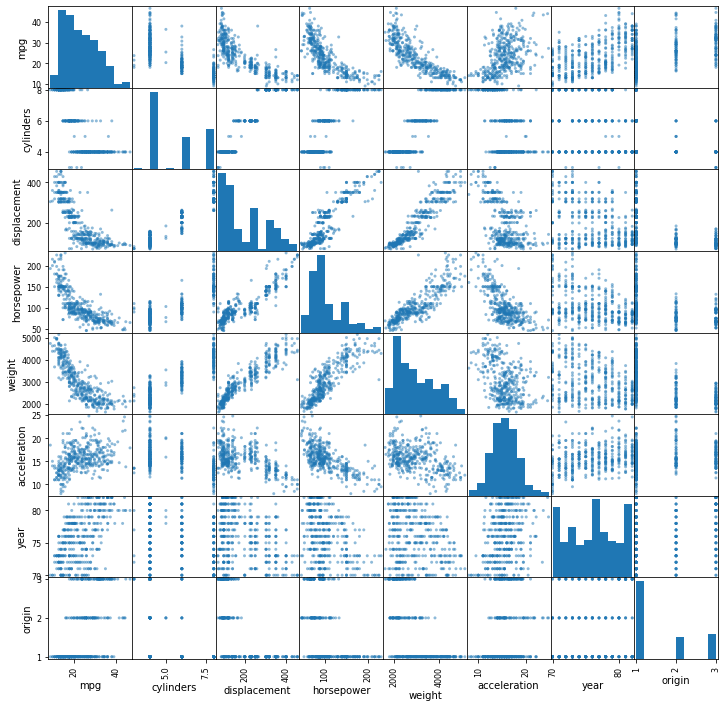

In [3]:
_ = pd.plotting.scatter_matrix(df, figsize=(12, 12))

<p>Based on these plots we will further investigate the $\mathrm{displacement}$, $\mathrm{horsepower}$ and $\mathrm{weight}$ variables.</p>

In [4]:
df_y = df[['mpg']].copy()
df_x = df[['displacement', 'horsepower', 'weight']].copy()

<p>Let us first test the polynomial models.</p>

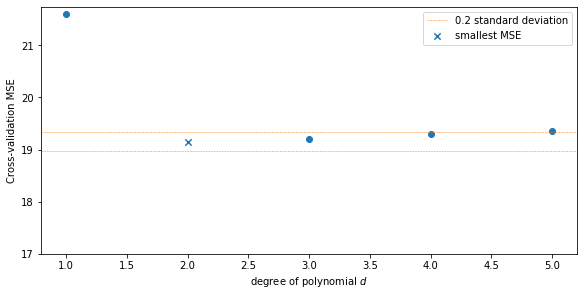

In [5]:
polynomialRegressionChooseOptimalDegree(df_x[['displacement']], df_y, total_degrees=5)

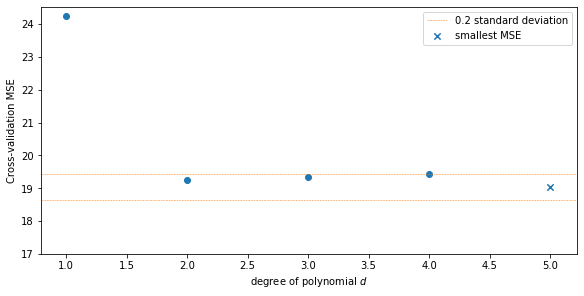

In [6]:
polynomialRegressionChooseOptimalDegree(df_x[['horsepower']], df_y, total_degrees=5)

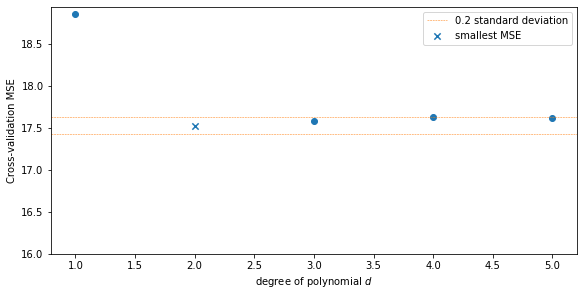

In [7]:
polynomialRegressionChooseOptimalDegree(df_x[['weight']], df_y, total_degrees=5)

In [8]:
total_degrees = 2
columns = df_x.columns
for independent in columns:
    for i in range(2, total_degrees + 1):
        variable_name = independent + str(i)
        df_x[variable_name] = df_x[independent]**i

df_x = df_x.reindex(sorted(df_x.columns), axis=1)
df_x.head()

,displacement,displacement2,horsepower,horsepower2,weight,weight2
name,,,,,,
chevrolet chevelle malibu,307.0,94249.0,130.0,16900.0,3504,12278016
buick skylark 320,350.0,122500.0,165.0,27225.0,3693,13638249
plymouth satellite,318.0,101124.0,150.0,22500.0,3436,11806096
amc rebel sst,304.0,92416.0,150.0,22500.0,3433,11785489
ford torino,302.0,91204.0,140.0,19600.0,3449,11895601


In [9]:
loocv = LeaveOneOut() # LeaveOneOut
MSE = 0
for train_index, test_index in loocv.split(df_x):
    df_x_train, df_x_test = df_x.iloc[train_index], df_x.iloc[test_index]
    df_y_train, df_y_test = df_y.iloc[train_index], df_y.iloc[test_index]

    model = LinearRegression()
    _ = model.fit(df_x_train, df_y_train)

    Y_pred = model.predict(df_x_test)
    MSE += (df_y_test.iloc[0, 0] - Y_pred[0, 0])**2        

print(f'MSE = {MSE / df_x.shape[0]}')

MSE = 15.547346629694578


<p>Now we will try the cubic splines with various amounts of knots.</p>

In [10]:
df_x = df_x[['displacement', 'horsepower', 'weight']]
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.1, random_state = 1)

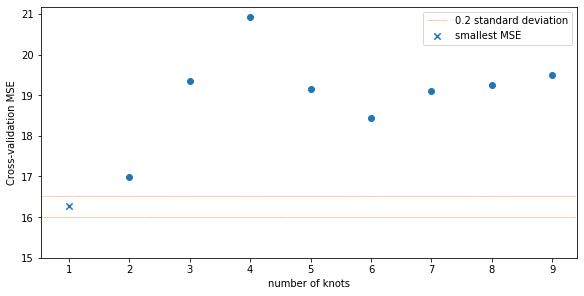

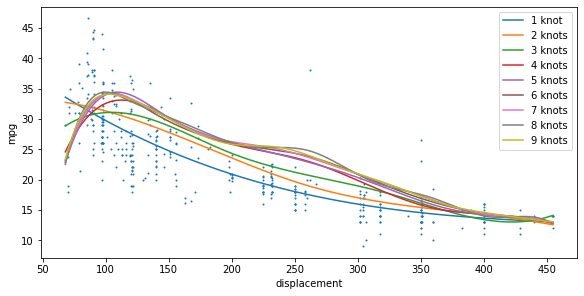

In [11]:
plotWrapperCubicSplines(df_x[['displacement']], df_x_train[['displacement']], df_x_test[['displacement']], df_y, df_y_train, df_y_test, natural=False)

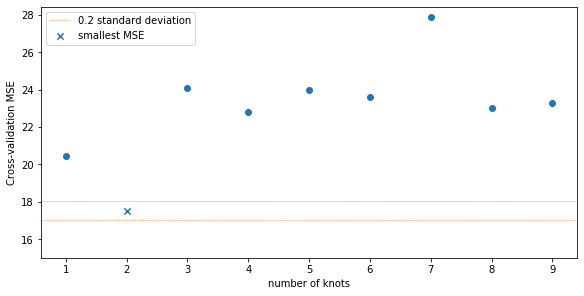

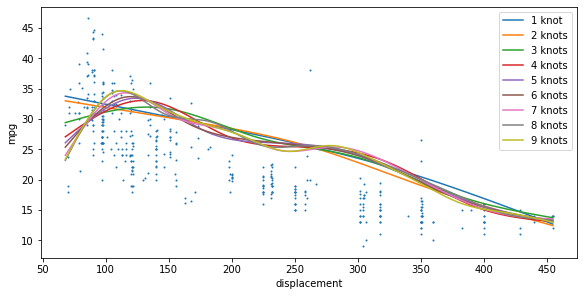

In [12]:
plotWrapperCubicSplines(df_x[['displacement']], df_x_train[['displacement']], df_x_test[['displacement']], df_y, df_y_train, df_y_test, natural=True)

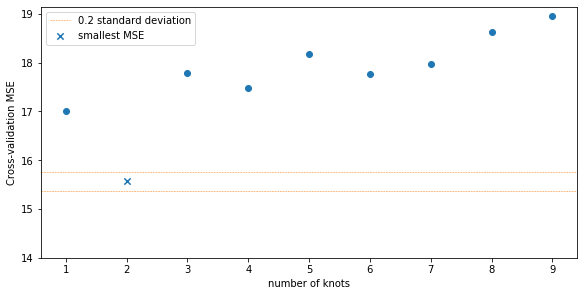

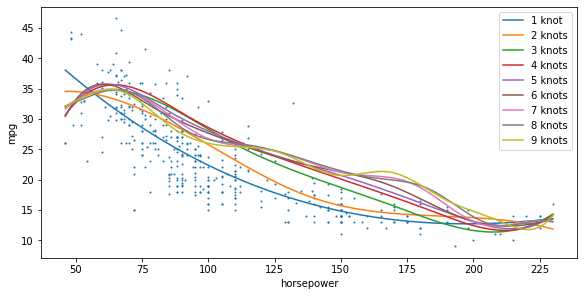

In [13]:
plotWrapperCubicSplines(df_x[['horsepower']], df_x_train[['horsepower']], df_x_test[['horsepower']], df_y, df_y_train, df_y_test, natural=False)

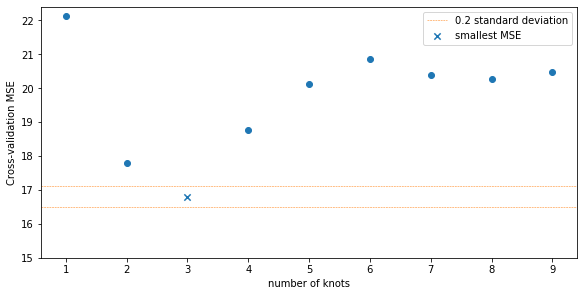

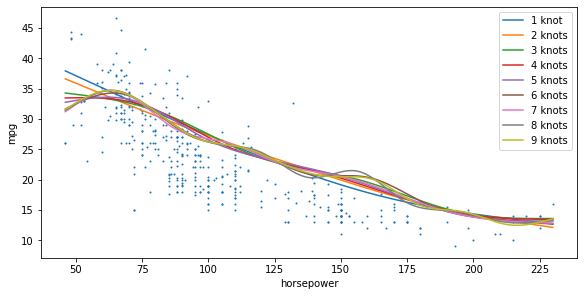

In [14]:
plotWrapperCubicSplines(df_x[['horsepower']], df_x_train[['horsepower']], df_x_test[['horsepower']], df_y, df_y_train, df_y_test, natural=True)

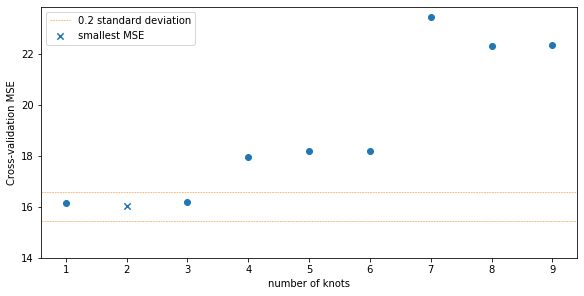

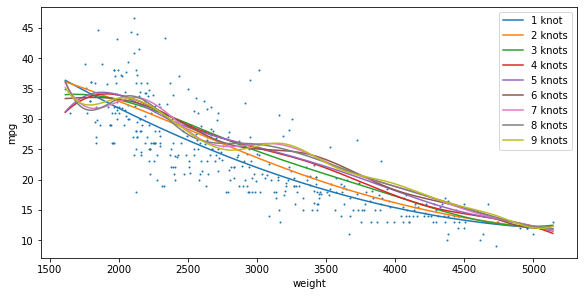

In [15]:
plotWrapperCubicSplines(df_x[['weight']], df_x_train[['weight']], df_x_test[['weight']], df_y, df_y_train, df_y_test, natural=False)

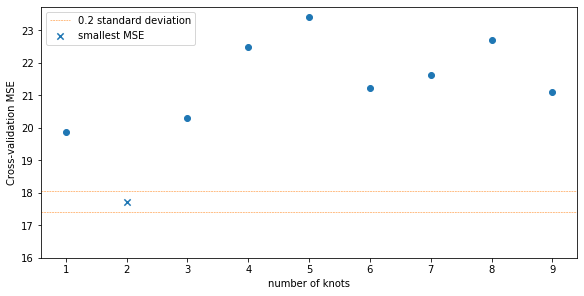

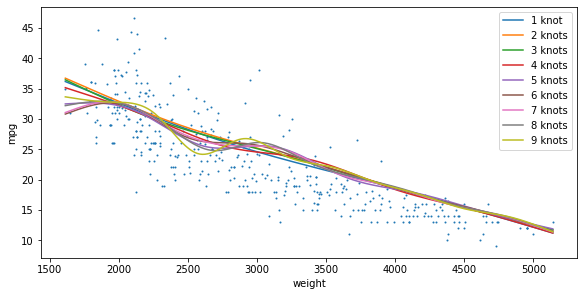

In [16]:
plotWrapperCubicSplines(df_x[['weight']], df_x_train[['weight']], df_x_test[['weight']], df_y, df_y_train, df_y_test, natural=True)

<p>Let us now extend the cubic splines as a GAM.</p>

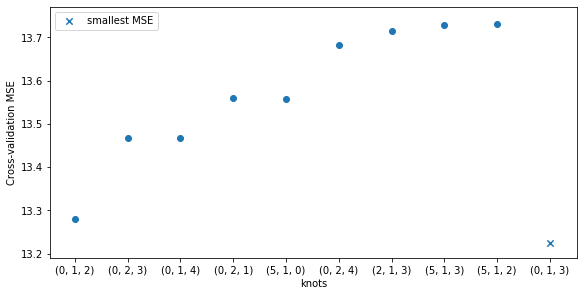

In [18]:
results = {}
perm_splines = permutations(list(range(4, 10)), 3) 
for n_splines in perm_splines:
    # https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f
    # fit a spline term on feature 0, 1 and 2
    gam = LinearGAM(s(0) + s(1) + s(2), n_splines=n_splines, fit_intercept=True,
                    lam=0, constraints=None).fit(df_x_train.to_numpy(), df_y_train.to_numpy())
    Y_pred = gam.predict(df_x_test)
    MSE = mean_squared_error(df_y_test, Y_pred)
    n_knots = tuple(splines-4 for splines in n_splines)
    results[str(n_knots)] = MSE


n_knots_arr = np.array(list(results.keys()))
MSE_arr = np.array(list(results.values()))

# plot best 'k' models
k = 10
idx = np.argpartition(MSE_arr, k)
n_knots_arr = n_knots_arr[idx[:k]]
MSE_arr = MSE_arr[idx[:k]]
std_dev = np.std(MSE_arr)

id_min = np.argmin(MSE_arr)
min_mse = n_knots_arr[id_min]  # we plot these 'best results' with a different marker
min_val = MSE_arr[id_min]  # we plot these 'best results' with a different marker
n_knots_arr = np.delete(n_knots_arr, id_min)
MSE_arr = np.delete(MSE_arr, id_min)

fig, ax1 = plt_func.subplots(1, 1, constrained_layout=True, figsize=(8, 4))
_ = ax1.scatter(n_knots_arr, MSE_arr)
_ = ax1.scatter(min_mse, min_val, marker='x', s=40, c=plt_func.rcParams['axes.prop_cycle'].by_key()['color'][0], label='smallest MSE')
_ = ax1.set_xlabel(r'knots')
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.legend()

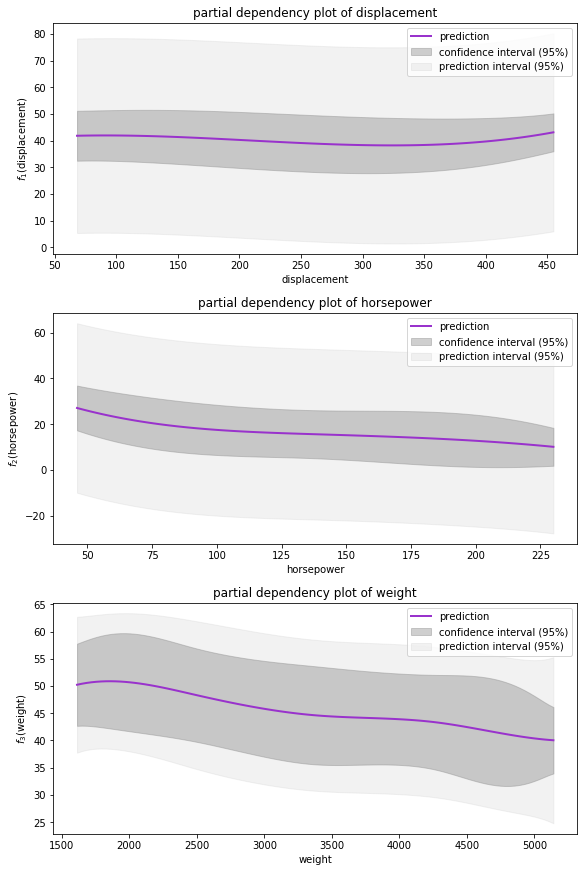

In [19]:
# partial dependency plots of best model with full dataset
n_knots = [0, 1, 3]
n_splines = [el + 4 for el in n_knots]
gam = LinearGAM(s(0) + s(1) + s(2), n_splines=n_splines, fit_intercept=True,
                    lam=0, constraints=None).fit(df_x.to_numpy(), df_y.to_numpy())
columns = df_x.columns
numberOfSubplots = df_x.shape[1]
confidence_width = 0.95
fig, axes = plt_func.subplots(numberOfSubplots, 1, constrained_layout=True, figsize=(8, 4*numberOfSubplots))
for i, ax in enumerate(axes):
    X_pred = gam.generate_X_grid(term=i)
    Y_pred = gam.predict(X_pred)
    
    partial_dependence, confidence_intervals = gam.partial_dependence(term=i, X=X_pred, width=confidence_width)
    lower_conf_int = confidence_intervals[:, 0]
    upper_conf_int = confidence_intervals[:, 1]

    diff = Y_pred[0] - partial_dependence[0]
    partial_dependence += diff
    lower_conf_int += diff
    upper_conf_int += diff
    
#     _ = ax.scatter(df_x[columns[i]], df_y, label='training data')
    _ = ax.plot(X_pred[:, i], partial_dependence, '-', color='darkorchid', linewidth=2, label='prediction')
    _ = ax.fill_between(X_pred[:, i], lower_conf_int, upper_conf_int, color='#888888', alpha=0.4, label=f"confidence interval ({int(confidence_width*100)}%)")
    
    prediction_intervals = gam.prediction_intervals(X_pred, width=confidence_width)
    lower_pred_int = prediction_intervals[:, 0]
    upper_pred_int = prediction_intervals[:, 1]
    _ = ax.fill_between(X_pred[:, i], lower_pred_int, upper_pred_int, color='#888888', alpha=0.1, label=f"prediction interval ({int(confidence_width*100)}%)")
    
    _ = ax.legend()
    _ = ax.set_xlabel(columns[i])
    _ = ax.set_ylabel(r'$f_{%s}(\mathrm{%s})$' % (i+1, columns[i]))
    _ = ax.set_title(f'partial dependency plot of {columns[i]}')

<p>We can also fit a GAM using smoothing splines.</p>

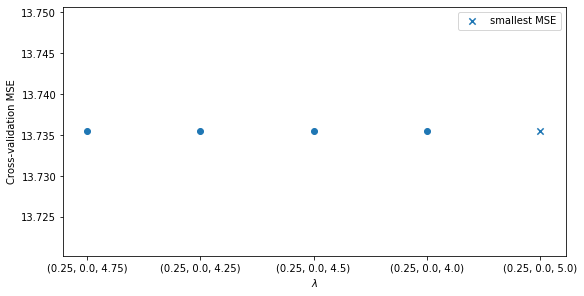

In [20]:
results = {}
perm_lambda = permutations(np.linspace(0, 5, 21, endpoint=True), 3) 
for lambda_ in perm_lambda:
    # https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f
    # fit a spline term on feature 0, 1 and 2
    gam = LinearGAM(s(0) + s(1) + s(2), n_splines=4, fit_intercept=True,
                    lam=lambda_, constraints=None).fit(df_x_train.to_numpy(), df_y_train.to_numpy())
    Y_pred = gam.predict(df_x_test)
    MSE = mean_squared_error(df_y_test, Y_pred)
    results[str(lambda_)] = MSE

lambda_arr = np.array(list(results.keys()))
MSE_arr = np.array(list(results.values()))

# plot best 'k' models
k = 5
idx = np.argpartition(MSE_arr, k)
lambda_arr = lambda_arr[idx[:k]]
MSE_arr = MSE_arr[idx[:k]]
std_dev = np.std(MSE_arr)

id_min = np.argmin(MSE_arr)
min_mse = lambda_arr[id_min]  # we plot these 'best results' with a different marker
min_val = MSE_arr[id_min]  # we plot these 'best results' with a different marker
lambda_arr = np.delete(lambda_arr, id_min)
MSE_arr = np.delete(MSE_arr, id_min)

fig, ax1 = plt_func.subplots(1, 1, constrained_layout=True, figsize=(8, 4))
_ = ax1.scatter(lambda_arr, MSE_arr)
_ = ax1.scatter(min_mse, min_val, marker='x', s=40, c=plt_func.rcParams['axes.prop_cycle'].by_key()['color'][0], label='smallest MSE')
_ = ax1.set_xlabel(r'$\lambda$')
_ = ax1.set_ylabel('Cross-validation MSE')
_ = ax1.legend()

<p>Finally, we use <code>pyGAM</code>'s <code>gridsearch()</code> method to search for the optimal smoothing parameters.</p>

In [21]:
gam = LinearGAM().gridsearch(df_x_train.to_numpy(), df_y_train.to_numpy())
Y_pred = gam.predict(df_x_test)
MSE = mean_squared_error(df_y_test, Y_pred)
print(f'MSE = {MSE}\n')
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


MSE = 13.872932416967803

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.7845
Link Function:                     IdentityLink Log Likelihood:                                 -1288.2127
Number of Samples:                          352 AIC:                                             2595.9944
                                                AICc:                                            2596.6129
                                                GCV:                                               15.7072
                                                Scale:                                             15.0032
                                                Pseudo R-Squared:                                   0.7561
Feature Fun

/home/floris/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """


<p>So overall, we see that the best performing model is the GAM with knots $0$, $1$ and $3$ for the features $\mathrm{displacement}$, $\mathrm{horsepower}$ and $\mathrm{weight}$, respectively.</p>